## Problem Satement
- Develop a robust machine learning pipeline to predict loan default risk, enabling better credit decisions and minimizing financial losses.


In [1]:
# importing neccessary libraies 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

### loading datasets 

In [2]:
df_demo='https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv'
df1=pd.read_csv(df_demo)

In [3]:
df_perf='https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv'
df2=pd.read_csv(df_perf)

In [4]:
df_pervl='https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv'
df3=pd.read_csv(df_pervl)

##### Demographic data (traindemographics.csv)(df1)

- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)

##### Performance data (trainperf.csv) (df2): This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

#####  Previous loans data (trainprevloans.csv)(df3) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)


## DATA CLEANING AND UNDERSTANDING OF DEMOGRAPHIC DATA 

In [5]:
df1.head()

customerid                   birthdate  \
0  8a858e135cb22031015cbafc76964ebd  1973-10-10 00:00:00.000000   
1  8a858e275c7ea5ec015c82482d7c3996  1986-01-21 00:00:00.000000   
2  8a858e5b5bd99460015bdc95cd485634  1987-04-01 00:00:00.000000   
3  8a858efd5ca70688015cabd1f1e94b55  1991-07-19 00:00:00.000000   
4  8a858e785acd3412015acd48f4920d04  1982-11-22 00:00:00.000000   

  bank_account_type  longitude_gps  latitude_gps bank_name_clients  \
0           Savings       3.319219      6.528604           GT Bank   
1           Savings       3.325598      7.119403     Sterling Bank   
2           Savings       5.746100      5.563174     Fidelity Bank   
3           Savings       3.362850      6.642485           GT Bank   
4           Savings       8.455332     11.971410           GT Bank   

  bank_branch_clients employment_status_clients level_of_education_clients  
0                 NaN                       NaN                        NaN  
1                 NaN                 Permanent                        NaN  
2                 NaN                       NaN                        NaN  
3                 NaN                 Permanent                        NaN  
4                 NaN                 Permanent                        NaN

In [6]:
df1.duplicated().sum()

12

In [7]:
# dropping duplicate 
df1=df1.drop_duplicates()

In [8]:
df1.duplicated().sum()

0

In [9]:
df1.shape

(4334, 9)

In [10]:
# checking the information of df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4334 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4334 non-null   object 
 1   birthdate                   4334 non-null   object 
 2   bank_account_type           4334 non-null   object 
 3   longitude_gps               4334 non-null   float64
 4   latitude_gps                4334 non-null   float64
 5   bank_name_clients           4334 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3686 non-null   object 
 8   level_of_education_clients  586 non-null    object 
dtypes: float64(2), object(7)
memory usage: 338.6+ KB


In [11]:
from datetime import date

In [12]:
df1['birthdate']=pd.to_datetime(df1['birthdate'])

In [13]:
df1.drop(columns=(['bank_branch_clients','level_of_education_clients']),inplace=True)

In [14]:
df1.employment_status_clients.unique()

array([nan, 'Permanent', 'Student', 'Self-Employed', 'Unemployed',
       'Retired', 'Contract'], dtype=object)

In [15]:
# Check for missing values count
df1['employment_status_clients'].isna().sum()

648

In [16]:

# Percentage of missing values
df1['employment_status_clients'].isna().mean() * 100

14.95154591601292

In [17]:
# See distribution of existing categories
df1['employment_status_clients'].value_counts(normalize=True)

employment_status_clients
Permanent        0.850244
Self-Employed    0.094411
Student          0.038524
Unemployed       0.015464
Retired          0.001085
Contract         0.000271
Name: proportion, dtype: float64

In [18]:
df1.employment_status_clients.fillna('unknown',inplace=True)

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4334 entries, 0 to 4345
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4334 non-null   object        
 1   birthdate                  4334 non-null   datetime64[ns]
 2   bank_account_type          4334 non-null   object        
 3   longitude_gps              4334 non-null   float64       
 4   latitude_gps               4334 non-null   float64       
 5   bank_name_clients          4334 non-null   object        
 6   employment_status_clients  4334 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 270.9+ KB


## Key point from Df1 Cleaning
###### Duplicate Removal
- Identified and removed duplicate records to prevent errors and ensure only accurate, unique data points were used in the analysis.

##### Data Type Correction
- The birthdate column was stored in an incorrect data type. It was converted to a proper datetime format to enable accurate date-based calculations.

##### Column Removal Due to High Missingness
- level_of_education_clients and bank_branch_clients contained more than 80% missing values.
- These columns were dropped, as the high proportion of missing data made them unreliable for analysis or modeling.

##### Handling Missing Values in Employment Status
- The employment_status_clients column contained missing values.
- All missing entries were replaced with "Unknown" to preserve transparency, avoid introducing bias, and retain the potential predictive value of missingness.

## DATA CLEANING AND UNDERSTANDING OF  PERFORMANCE DATA

In [20]:
df2.head()

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   
2  8a8588f35438fe12015444567666018e     301966580           7   
3  8a85890754145ace015429211b513e16     301999343           3   
4  8a858970548359cc0154883481981866     301962360           9   

                 approveddate                creationdate  loanamount  \
0  2017-07-25 08:22:56.000000  2017-07-25 07:22:47.000000     30000.0   
1  2017-07-05 17:04:41.000000  2017-07-05 16:04:18.000000     15000.0   
2  2017-07-06 14:52:57.000000  2017-07-06 13:52:51.000000     20000.0   
3  2017-07-27 19:00:41.000000  2017-07-27 18:00:35.000000     10000.0   
4  2017-07-03 23:42:45.000000  2017-07-03 22:42:39.000000     40000.0   

   totaldue  termdays referredby good_bad_flag  
0   34500.0        30        NaN          Good  
1   17250.0        30        NaN          Good  
2   22250.0        15        NaN          Good  
3   11500.0        15        NaN          Good  
4   44000.0        30        NaN          Good

In [21]:
df2.duplicated().sum()

0

In [22]:
df2.shape

(4368, 10)

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [24]:
df2.drop(columns='referredby',inplace=True)

In [25]:
df2['approveddate']=pd.to_datetime(df2['approveddate'])
df2['creationdate']=pd.to_datetime(df2['creationdate'])


In [26]:
df2.isna().sum()

customerid       0
systemloanid     0
loannumber       0
approveddate     0
creationdate     0
loanamount       0
totaldue         0
termdays         0
good_bad_flag    0
dtype: int64

In [27]:
# recheck df2 information
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customerid     4368 non-null   object        
 1   systemloanid   4368 non-null   int64         
 2   loannumber     4368 non-null   int64         
 3   approveddate   4368 non-null   datetime64[ns]
 4   creationdate   4368 non-null   datetime64[ns]
 5   loanamount     4368 non-null   float64       
 6   totaldue       4368 non-null   float64       
 7   termdays       4368 non-null   int64         
 8   good_bad_flag  4368 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 307.3+ KB


## Key point from Data2 cleaning 
##### Dublicated Removal
- No dubliacte column in the data 2 
##### Data type correction
- approveddate and approveddate was stored in an incorrect data type. It was converted to a proper datetime format to enable accurate date-based calculations
##### Column Removal
- referredby has contained more than 80% missing values.
- This columns was dropped, as the high proportion of missing data made them unreliable for analysis or modeling

##### Data type correction
- approveddate and approveddate was stored in an incorrect data type. It was converted to a proper datetime format to enable accurate date-based calculations##### Data type correction
- approveddate and approveddate was stored in an incorrect data type. It was converted to a proper datetime format to enable accurate date-based calculations

## DATA CLEANING AND UNDERSTANDING OF  PREVLOANS DATA

In [28]:
df3.head()

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   
3  8a8588f35438fe12015444567666018e     301861541           5   
4  8a85890754145ace015429211b513e16     301941754           2   

                 approveddate                creationdate  loanamount  \
0  2016-08-15 18:22:40.000000  2016-08-15 17:22:32.000000     10000.0   
1  2017-04-28 18:39:07.000000  2017-04-28 17:38:53.000000     10000.0   
2  2017-03-05 10:56:25.000000  2017-03-05 09:56:19.000000     20000.0   
3  2017-04-09 18:25:55.000000  2017-04-09 17:25:42.000000     10000.0   
4  2017-06-17 09:29:57.000000  2017-06-17 08:29:50.000000     10000.0   

   totaldue  termdays                  closeddate referredby  \
0   13000.0        30  2016-09-01 16:06:48.000000        NaN   
1   13000.0        30  2017-05-28 14:44:49.000000        NaN   
2   23800.0        30  2017-04-26 22:18:56.000000        NaN   
3   11500.0        15  2017-04-24 01:35:52.000000        NaN   
4   11500.0        15  2017-07-14 21:18:43.000000        NaN   

                 firstduedate             firstrepaiddate  
0  2016-09-14 00:00:00.000000  2016-09-01 15:51:43.000000  
1  2017-05-30 00:00:00.000000  2017-05-26 00:00:00.000000  
2  2017-04-04 00:00:00.000000  2017-04-26 22:03:47.000000  
3  2017-04-24 00:00:00.000000  2017-04-24 00:48:43.000000  
4  2017-07-03 00:00:00.000000  2017-07-14 21:08:35.000000

In [29]:
df3.shape

(18183, 12)

In [30]:
df3.duplicated().sum()

0

In [31]:
#rechecking df3 information
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   referredby       1026 non-null   object 
 10  firstduedate     18183 non-null  object 
 11  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [32]:
df3['closeddate ']=pd.to_datetime(df3['closeddate'])
df3['firstduedate']=pd.to_datetime(df3['firstduedate'])
df3['firstrepaiddate']=pd.to_datetime(df3['firstrepaiddate'])

In [33]:
df3['prev_overdue_days'] = (df3['firstrepaiddate'] - df3['firstduedate']).dt.days

firstduedate → the date the customer was supposed to make their first repayment.

firstrepaiddate → the date the customer actually made their first repayment.

By subtracting the two dates and converting with .dt.days, you calculate the number of days difference.

So:

- If prev_overdue_days = 0 → repayment was made on time.

- If prev_overdue_days > 0 → repayment was made late (days overdue).

- If prev_overdue_days < 0 → repayment was made earlier than due date (paid early).

In [34]:
df3.head()

customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1  8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2  8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   
3  8a8588f35438fe12015444567666018e     301861541           5   
4  8a85890754145ace015429211b513e16     301941754           2   

                 approveddate                creationdate  loanamount  \
0  2016-08-15 18:22:40.000000  2016-08-15 17:22:32.000000     10000.0   
1  2017-04-28 18:39:07.000000  2017-04-28 17:38:53.000000     10000.0   
2  2017-03-05 10:56:25.000000  2017-03-05 09:56:19.000000     20000.0   
3  2017-04-09 18:25:55.000000  2017-04-09 17:25:42.000000     10000.0   
4  2017-06-17 09:29:57.000000  2017-06-17 08:29:50.000000     10000.0   

   totaldue  termdays                  closeddate referredby firstduedate  \
0   13000.0        30  2016-09-01 16:06:48.000000        NaN   2016-09-14   
1   13000.0        30  2017-05-28 14:44:49.000000        NaN   2017-05-30   
2   23800.0        30  2017-04-26 22:18:56.000000        NaN   2017-04-04   
3   11500.0        15  2017-04-24 01:35:52.000000        NaN   2017-04-24   
4   11500.0        15  2017-07-14 21:18:43.000000        NaN   2017-07-03   

      firstrepaiddate         closeddate   prev_overdue_days  
0 2016-09-01 15:51:43 2016-09-01 16:06:48                -13  
1 2017-05-26 00:00:00 2017-05-28 14:44:49                 -4  
2 2017-04-26 22:03:47 2017-04-26 22:18:56                 22  
3 2017-04-24 00:48:43 2017-04-24 01:35:52                  0  
4 2017-07-14 21:08:35 2017-07-14 21:18:43                 11

In [35]:
previous_loan= df3.groupby('customerid')['prev_overdue_days'].mean().reset_index()

In [36]:
print(previous_loan)

                            customerid  prev_overdue_days
0     8a1088a0484472eb01484669e3ce4e0b           6.000000
1     8a1a1e7e4f707f8b014f797718316cad          -0.250000
2     8a1a32fc49b632520149c3b8fdf85139          -0.428571
3     8a1eb5ba49a682300149c3c068b806c7          -3.125000
4     8a1edbf14734127f0147356fdb1b1eb2          -4.000000
...                                ...                ...
4354  8a858fff5a28d297015a33bc2e845305         -13.000000
4355  8a858fff5a36fe68015a37f8550a02a2          -3.000000
4356  8a858fff5a36fe68015a3ac5851618ab          -2.000000
4357  8a858fff5a36fe68015a3b8dcb8a3843          -2.833333
4358  8a858fff5c79144c015c7bdbfc086ce1          -5.000000

[4359 rows x 2 columns]


In [37]:
df3

customerid  systemloanid  loannumber  \
0      8a2a81a74ce8c05d014cfb32a0da1049     301682320           2   
1      8a2a81a74ce8c05d014cfb32a0da1049     301883808           9   
2      8a2a81a74ce8c05d014cfb32a0da1049     301831714           8   
3      8a8588f35438fe12015444567666018e     301861541           5   
4      8a85890754145ace015429211b513e16     301941754           2   
...                                 ...           ...         ...   
18178  8a858899538ddb8e0153a2b555421fc5     301611754           2   
18179  8a858899538ddb8e0153a2b555421fc5     301761267           9   
18180  8a858899538ddb8e0153a2b555421fc5     301631653           4   
18181  8a858f0656b7820c0156c92ca3ba436f     301697691           1   
18182  8a858faf5679a838015688de3028143d     301715255           2   

                     approveddate                creationdate  loanamount  \
0      2016-08-15 18:22:40.000000  2016-08-15 17:22:32.000000     10000.0   
1      2017-04-28 18:39:07.000000  2017-04-28 17:38:53.000000     10000.0   
2      2017-03-05 10:56:25.000000  2017-03-05 09:56:19.000000     20000.0   
3      2017-04-09 18:25:55.000000  2017-04-09 17:25:42.000000     10000.0   
4      2017-06-17 09:29:57.000000  2017-06-17 08:29:50.000000     10000.0   
...                           ...                         ...         ...   
18178  2016-04-16 13:36:34.000000  2016-04-16 12:36:28.000000     10000.0   
18179  2016-11-18 14:26:07.000000  2016-11-18 13:25:51.000000     30000.0   
18180  2016-06-12 15:30:56.000000  2016-06-12 14:30:50.000000     10000.0   
18181  2016-08-27 20:03:45.000000  2016-08-27 19:03:34.000000     10000.0   
18182  2016-09-14 23:42:14.000000  2016-09-14 22:42:05.000000     10000.0   

       totaldue  termdays                  closeddate referredby firstduedate  \
0       13000.0        30  2016-09-01 16:06:48.000000        NaN   2016-09-14   
1       13000.0        30  2017-05-28 14:44:49.000000        NaN   2017-05-30   
2       23800.0        30  2017-04-26 22:18:56.000000        NaN   2017-04-04   
3       11500.0        15  2017-04-24 01:35:52.000000        NaN   2017-04-24   
4       11500.0        15  2017-07-14 21:18:43.000000        NaN   2017-07-03   
...         ...       ...                         ...        ...          ...   
18178   13000.0        30  2016-05-14 00:04:52.000000        NaN   2016-05-16   
18179   34400.0        30  2016-12-13 16:08:57.000000        NaN   2016-12-19   
18180   13000.0        30  2016-07-09 15:39:00.000000        NaN   2016-07-12   
18181   13000.0        30  2016-10-15 10:17:54.000000        NaN   2016-09-26   
18182   13000.0        30  2016-09-29 19:51:04.000000        NaN   2016-10-14   

          firstrepaiddate         closeddate   prev_overdue_days  
0     2016-09-01 15:51:43 2016-09-01 16:06:48                -13  
1     2017-05-26 00:00:00 2017-05-28 14:44:49                 -4  
2     2017-04-26 22:03:47 2017-04-26 22:18:56                 22  
3     2017-04-24 00:48:43 2017-04-24 01:35:52                  0  
4     2017-07-14 21:08:35 2017-07-14 21:18:43                 11  
...                   ...                 ...                ...  
18178 2016-05-13 18:05:07 2016-05-14 00:04:52                 -3  
18179 2016-12-13 15:53:48 2016-12-13 16:08:57                 -6  
18180 2016-07-09 15:23:56 2016-07-09 15:39:00                 -3  
18181 2016-10-15 10:02:45 2016-10-15 10:17:54                 19  
18182 2016-09-29 19:35:55 2016-09-29 19:51:04                -15  

[18183 rows x 14 columns]

In [38]:
df3.duplicated().sum()

0

### Observation from DataFrame 3 (df3) Cleaning
#### Data Type Correction
The approveddate column was identified as having an incorrect data type. It was transformed into a proper datetime format to facilitate accurate temporal analyses.

##### Feature Transformation
A new feature, days_overdue, was engineered by calculating the difference between firstrepaiddate and firstduedate. This feature quantifies the duration (in days) that a customer took to repay the loan after the due date: a positive value indicates late repayment, a negative value indicates early repayment, and a value of zero indicates on-time repayment.

The days_overdue feature was then aggregated by customerid to determine the average overdue days per customer, offering valuable insights into typical repayment patterns.

### MERGING OF THE DATA 

In [39]:
df_merged=df2.merge(previous_loan, on='customerid', how='left')

In [40]:
df_merged

customerid  systemloanid  loannumber  \
0     8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1     8a85886e54beabf90154c0a29ae757c0     301965204           2   
2     8a8588f35438fe12015444567666018e     301966580           7   
3     8a85890754145ace015429211b513e16     301999343           3   
4     8a858970548359cc0154883481981866     301962360           9   
...                                ...           ...         ...   
4363  8a858e6d58b0cc520158beeb14b22a5a     302003163           2   
4364  8a858ee85cf400f5015cf44ab1c42d5c     301998967           2   
4365  8a858f365b2547f3015b284597147c94     301995576           3   
4366  8a858f935ca09667015ca0ee3bc63f51     301977679           2   
4367  8a858fd458639fcc015868eb14b542ad     301967124           8   

            approveddate        creationdate  loanamount  totaldue  termdays  \
0    2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1    2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   
2    2017-07-06 14:52:57 2017-07-06 13:52:51     20000.0   22250.0        15   
3    2017-07-27 19:00:41 2017-07-27 18:00:35     10000.0   11500.0        15   
4    2017-07-03 23:42:45 2017-07-03 22:42:39     40000.0   44000.0        30   
...                  ...                 ...         ...       ...       ...   
4363 2017-07-30 09:19:42 2017-07-30 08:18:30     10000.0   13000.0        30   
4364 2017-07-27 15:35:47 2017-07-27 14:35:40     10000.0   13000.0        30   
4365 2017-07-25 16:25:57 2017-07-25 15:24:47     10000.0   11500.0        15   
4366 2017-07-14 13:50:27 2017-07-14 12:50:21     10000.0   13000.0        30   
4367 2017-07-06 21:01:06 2017-07-06 20:01:01     30000.0   34500.0        30   

     good_bad_flag  prev_overdue_days  
0             Good          -0.909091  
1             Good                NaN  
2             Good           0.833333  
3             Good           7.500000  
4             Good          -3.125000  
...            ...                ...  
4363           Bad           5.000000  
4364           Bad          -4.000000  
4365           Bad           8.000000  
4366           Bad           0.000000  
4367           Bad          -3.428571  

[4368 rows x 10 columns]

In [41]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerid         4368 non-null   object        
 1   systemloanid       4368 non-null   int64         
 2   loannumber         4368 non-null   int64         
 3   approveddate       4368 non-null   datetime64[ns]
 4   creationdate       4368 non-null   datetime64[ns]
 5   loanamount         4368 non-null   float64       
 6   totaldue           4368 non-null   float64       
 7   termdays           4368 non-null   int64         
 8   good_bad_flag      4368 non-null   object        
 9   prev_overdue_days  4359 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 341.4+ KB


In [42]:
df_merged['prev_overdue_days'].isna().sum()

9

In [43]:
df_merged['prev_overdue_days'] = df_merged['prev_overdue_days'].fillna(0)

In [44]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerid         4368 non-null   object        
 1   systemloanid       4368 non-null   int64         
 2   loannumber         4368 non-null   int64         
 3   approveddate       4368 non-null   datetime64[ns]
 4   creationdate       4368 non-null   datetime64[ns]
 5   loanamount         4368 non-null   float64       
 6   totaldue           4368 non-null   float64       
 7   termdays           4368 non-null   int64         
 8   good_bad_flag      4368 non-null   object        
 9   prev_overdue_days  4368 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 341.4+ KB


In [45]:
df_merged['prev_overdue_days'].isna().sum()

0

From the merged datasets, analysis identified that nine customers were first-time borrowers with no prior loan history. As a result, missing values in the prev_overdue_days column were imputed with zeros to accurately represent their status as new borrowers. This imputation strategy ensures that the lack of previous repayment records is not mistakenly interpreted as late repayment, but rather correctly signifies the absence of any overdue history.

In [46]:
df=df_merged.merge(df1 ,on='customerid', how='left').round(2)

In [47]:
df

customerid  systemloanid  loannumber  \
0     8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1     8a85886e54beabf90154c0a29ae757c0     301965204           2   
2     8a8588f35438fe12015444567666018e     301966580           7   
3     8a85890754145ace015429211b513e16     301999343           3   
4     8a858970548359cc0154883481981866     301962360           9   
...                                ...           ...         ...   
4363  8a858e6d58b0cc520158beeb14b22a5a     302003163           2   
4364  8a858ee85cf400f5015cf44ab1c42d5c     301998967           2   
4365  8a858f365b2547f3015b284597147c94     301995576           3   
4366  8a858f935ca09667015ca0ee3bc63f51     301977679           2   
4367  8a858fd458639fcc015868eb14b542ad     301967124           8   

            approveddate        creationdate  loanamount  totaldue  termdays  \
0    2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1    2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   
2    2017-07-06 14:52:57 2017-07-06 13:52:51     20000.0   22250.0        15   
3    2017-07-27 19:00:41 2017-07-27 18:00:35     10000.0   11500.0        15   
4    2017-07-03 23:42:45 2017-07-03 22:42:39     40000.0   44000.0        30   
...                  ...                 ...         ...       ...       ...   
4363 2017-07-30 09:19:42 2017-07-30 08:18:30     10000.0   13000.0        30   
4364 2017-07-27 15:35:47 2017-07-27 14:35:40     10000.0   13000.0        30   
4365 2017-07-25 16:25:57 2017-07-25 15:24:47     10000.0   11500.0        15   
4366 2017-07-14 13:50:27 2017-07-14 12:50:21     10000.0   13000.0        30   
4367 2017-07-06 21:01:06 2017-07-06 20:01:01     30000.0   34500.0        30   

     good_bad_flag  prev_overdue_days  birthdate bank_account_type  \
0             Good              -0.91 1972-01-15             Other   
1             Good               0.00 1985-08-23           Savings   
2             Good               0.83 1984-09-18             Other   
3             Good               7.50 1977-10-10           Savings   
4             Good              -3.12 1986-09-07             Other   
...            ...                ...        ...               ...   
4363           Bad               5.00        NaT               NaN   
4364           Bad              -4.00 1989-12-04           Savings   
4365           Bad               8.00 1989-11-21           Savings   
4366           Bad               0.00 1990-06-11           Savings   
4367           Bad              -3.43 1988-08-16           Savings   

      longitude_gps  latitude_gps bank_name_clients employment_status_clients  
0              3.43          6.43      Diamond Bank                 Permanent  
1              3.89          7.32           GT Bank                 Permanent  
2             11.14         10.29           EcoBank                 Permanent  
3              3.99          7.49        First Bank                 Permanent  
4              7.46          9.08           GT Bank                 Permanent  
...             ...           ...               ...                       ...  
4363            NaN           NaN               NaN                       NaN  
4364           4.61          8.46              FCMB                 Permanent  
4365           3.98          7.41        First Bank                 Permanent  
4366           3.99          7.39         Skye Bank                 Permanent  
4367           3.73          6.47           GT Bank                   unknown  

[4368 rows x 16 columns]

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4368 non-null   object        
 1   systemloanid               4368 non-null   int64         
 2   loannumber                 4368 non-null   int64         
 3   approveddate               4368 non-null   datetime64[ns]
 4   creationdate               4368 non-null   datetime64[ns]
 5   loanamount                 4368 non-null   float64       
 6   totaldue                   4368 non-null   float64       
 7   termdays                   4368 non-null   int64         
 8   good_bad_flag              4368 non-null   object        
 9   prev_overdue_days          4368 non-null   float64       
 10  birthdate                  3269 non-null   datetime64[ns]
 11  bank_account_type          3269 non-null   object        
 12  longit

In [49]:
# calculating the missing percentage 

missing_percentage = df.isna().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_percentage)


birthdate                    25.160256
bank_account_type            25.160256
longitude_gps                25.160256
latitude_gps                 25.160256
bank_name_clients            25.160256
employment_status_clients    25.160256
dtype: float64


"The percentage of missing values was calculated for each column to guide the selection of the most appropriate imputation strategy."

In [50]:
df['bank_account_type'] = df['bank_account_type'].fillna(df['bank_account_type'].mode()[0])
df['bank_name_clients'] = df['bank_name_clients'].fillna(df['bank_name_clients'].mode()[0])
df['employment_status_clients'] = df['employment_status_clients'].fillna(df['employment_status_clients'].mode()[0])

The categorical columns ['bank_account_type', 'bank_name_clients', 'employment_status_clients'] contained missing values. To address this, mode imputation was applied, replacing missing values with the most frequent category in each column.

Justification:

1. Mode imputation ensures that missing values are filled with the most representative category in the dataset, thereby preserving the natural distribution of the data.
2. This approach avoids the introduction of an artificial "Unknown" category, which could add noise and diminish model interpretability, particularly when the number of missing values is low.
3. The method aligns with business logic; for instance, if the majority of customers have savings accounts or permanent employment status, it is reasonable to assume that missing cases are likely to fall into the predominant category.
4. Mode imputation reduces bias compared to filling missing values with rare or arbitrary categories.


In [51]:
from datetime import datetime

today = pd.Timestamp(datetime.today())
df['age'] = (today - df['birthdate']).dt.days // 365


##### A new column age was created in the dataset.

- age is now an integer feature representing each customer’s age in years.
- This transformation improves usability in statistical analysis and machine learning, since models handle numerical variables more effectively than raw date values.

In [52]:
median_age=df['age'].median()

In [53]:
median_age

40.0

In [54]:
df['age']=df['age'].fillna(median_age)

Note, The median is robust against outliers and better reflects the typical customer age, making it the most reliable choice for imputing missing values in this dataset.

In [55]:
df['longitude_gps'] = df['longitude_gps'].fillna(df['longitude_gps'].median())
df['latitude_gps'] = df['latitude_gps'].fillna(df['latitude_gps'].median())


##### In the dataset, some records had missing values for longitude and latitude, which represent the customer’s geographical location. Since location is a continuous numerical variable and may contain outliers, the median was chosen as the imputation strategy

In [56]:
df

customerid  systemloanid  loannumber  \
0     8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1     8a85886e54beabf90154c0a29ae757c0     301965204           2   
2     8a8588f35438fe12015444567666018e     301966580           7   
3     8a85890754145ace015429211b513e16     301999343           3   
4     8a858970548359cc0154883481981866     301962360           9   
...                                ...           ...         ...   
4363  8a858e6d58b0cc520158beeb14b22a5a     302003163           2   
4364  8a858ee85cf400f5015cf44ab1c42d5c     301998967           2   
4365  8a858f365b2547f3015b284597147c94     301995576           3   
4366  8a858f935ca09667015ca0ee3bc63f51     301977679           2   
4367  8a858fd458639fcc015868eb14b542ad     301967124           8   

            approveddate        creationdate  loanamount  totaldue  termdays  \
0    2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1    2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   
2    2017-07-06 14:52:57 2017-07-06 13:52:51     20000.0   22250.0        15   
3    2017-07-27 19:00:41 2017-07-27 18:00:35     10000.0   11500.0        15   
4    2017-07-03 23:42:45 2017-07-03 22:42:39     40000.0   44000.0        30   
...                  ...                 ...         ...       ...       ...   
4363 2017-07-30 09:19:42 2017-07-30 08:18:30     10000.0   13000.0        30   
4364 2017-07-27 15:35:47 2017-07-27 14:35:40     10000.0   13000.0        30   
4365 2017-07-25 16:25:57 2017-07-25 15:24:47     10000.0   11500.0        15   
4366 2017-07-14 13:50:27 2017-07-14 12:50:21     10000.0   13000.0        30   
4367 2017-07-06 21:01:06 2017-07-06 20:01:01     30000.0   34500.0        30   

     good_bad_flag  prev_overdue_days  birthdate bank_account_type  \
0             Good              -0.91 1972-01-15             Other   
1             Good               0.00 1985-08-23           Savings   
2             Good               0.83 1984-09-18             Other   
3             Good               7.50 1977-10-10           Savings   
4             Good              -3.12 1986-09-07             Other   
...            ...                ...        ...               ...   
4363           Bad               5.00        NaT           Savings   
4364           Bad              -4.00 1989-12-04           Savings   
4365           Bad               8.00 1989-11-21           Savings   
4366           Bad               0.00 1990-06-11           Savings   
4367           Bad              -3.43 1988-08-16           Savings   

      longitude_gps  latitude_gps bank_name_clients employment_status_clients  \
0              3.43          6.43      Diamond Bank                 Permanent   
1              3.89          7.32           GT Bank                 Permanent   
2             11.14         10.29           EcoBank                 Permanent   
3              3.99          7.49        First Bank                 Permanent   
4              7.46          9.08           GT Bank                 Permanent   
...             ...           ...               ...                       ...   
4363           3.58          6.63           GT Bank                 Permanent   
4364           4.61          8.46              FCMB                 Permanent   
4365           3.98          7.41        First Bank                 Permanent   
4366           3.99          7.39         Skye Bank                 Permanent   
4367           3.73          6.47           GT Bank                   unknown   

       age  
0     53.0  
1     40.0  
2     40.0  
3     47.0  
4     39.0  
...    ...  
4363  40.0  
4364  35.0  
4365  35.0  
4366  35.0  
4367  37.0  

[4368 rows x 17 columns]

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4368 non-null   object        
 1   systemloanid               4368 non-null   int64         
 2   loannumber                 4368 non-null   int64         
 3   approveddate               4368 non-null   datetime64[ns]
 4   creationdate               4368 non-null   datetime64[ns]
 5   loanamount                 4368 non-null   float64       
 6   totaldue                   4368 non-null   float64       
 7   termdays                   4368 non-null   int64         
 8   good_bad_flag              4368 non-null   object        
 9   prev_overdue_days          4368 non-null   float64       
 10  birthdate                  3269 non-null   datetime64[ns]
 11  bank_account_type          4368 non-null   object        
 12  longit

In [58]:
# drop birthday column
df.drop(columns='birthdate',inplace=True)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4368 non-null   object        
 1   systemloanid               4368 non-null   int64         
 2   loannumber                 4368 non-null   int64         
 3   approveddate               4368 non-null   datetime64[ns]
 4   creationdate               4368 non-null   datetime64[ns]
 5   loanamount                 4368 non-null   float64       
 6   totaldue                   4368 non-null   float64       
 7   termdays                   4368 non-null   int64         
 8   good_bad_flag              4368 non-null   object        
 9   prev_overdue_days          4368 non-null   float64       
 10  bank_account_type          4368 non-null   object        
 11  longitude_gps              4368 non-null   float64       
 12  latitu

In [60]:
df.to_csv('project_data.csv', index= False)

## Future Engineering 

In [61]:
def previous_loan_status(status):
    if status <= 0:
        return 'Good Borrower'
    elif status <= 7:
        return 'Minor Lateness (Watchlist)'
    else:
        return 'Risky (Potential Defaulter)'

df['Previous_loan_status'] = df['prev_overdue_days'].apply(previous_loan_status)

To assess borrower risk levels, the variable prev_overdue_days was transformed into a categorical feature, Previous_loan_status, using the following rule-based classification:

Good Borrower (≤ 0 days): Customers who repaid on or before the due date.

Minor Lateness (1–7 days): Customers who delayed repayment slightly.

Risky Borrower (> 7 days): Customers with significant repayment delays.

This categorization provides a simple but effective framework for distinguishing between low-risk and high-risk borrowers.

In [62]:
df['age']=df.age.astype(int)

In [63]:
df.age.unique()

array([53, 40, 47, 39, 36, 37, 38, 42, 60, 48, 46, 44, 43, 49, 32, 33, 41,
       34, 31, 50, 63, 55, 45, 29, 51, 54, 30, 35, 58, 59, 52, 57, 56, 62,
       61])

In [64]:
df['age_group']=pd.cut(df['age'],bins=(18,25,35,50,60,100), labels=('Youth','Young Adults','Middle-Aged','Pre-Retirement','Retired '))

This code creates a new categorical column, age_group, that segments customers into meaningful age ranges. This is useful for analyzing borrowing behavior, credit risk, or default patterns across different life stages.

In [65]:
df.shape

(4368, 18)

In [66]:
df

customerid  systemloanid  loannumber  \
0     8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1     8a85886e54beabf90154c0a29ae757c0     301965204           2   
2     8a8588f35438fe12015444567666018e     301966580           7   
3     8a85890754145ace015429211b513e16     301999343           3   
4     8a858970548359cc0154883481981866     301962360           9   
...                                ...           ...         ...   
4363  8a858e6d58b0cc520158beeb14b22a5a     302003163           2   
4364  8a858ee85cf400f5015cf44ab1c42d5c     301998967           2   
4365  8a858f365b2547f3015b284597147c94     301995576           3   
4366  8a858f935ca09667015ca0ee3bc63f51     301977679           2   
4367  8a858fd458639fcc015868eb14b542ad     301967124           8   

            approveddate        creationdate  loanamount  totaldue  termdays  \
0    2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1    2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   
2    2017-07-06 14:52:57 2017-07-06 13:52:51     20000.0   22250.0        15   
3    2017-07-27 19:00:41 2017-07-27 18:00:35     10000.0   11500.0        15   
4    2017-07-03 23:42:45 2017-07-03 22:42:39     40000.0   44000.0        30   
...                  ...                 ...         ...       ...       ...   
4363 2017-07-30 09:19:42 2017-07-30 08:18:30     10000.0   13000.0        30   
4364 2017-07-27 15:35:47 2017-07-27 14:35:40     10000.0   13000.0        30   
4365 2017-07-25 16:25:57 2017-07-25 15:24:47     10000.0   11500.0        15   
4366 2017-07-14 13:50:27 2017-07-14 12:50:21     10000.0   13000.0        30   
4367 2017-07-06 21:01:06 2017-07-06 20:01:01     30000.0   34500.0        30   

     good_bad_flag  prev_overdue_days bank_account_type  longitude_gps  \
0             Good              -0.91             Other           3.43   
1             Good               0.00           Savings           3.89   
2             Good               0.83             Other          11.14   
3             Good               7.50           Savings           3.99   
4             Good              -3.12             Other           7.46   
...            ...                ...               ...            ...   
4363           Bad               5.00           Savings           3.58   
4364           Bad              -4.00           Savings           4.61   
4365           Bad               8.00           Savings           3.98   
4366           Bad               0.00           Savings           3.99   
4367           Bad              -3.43           Savings           3.73   

      latitude_gps bank_name_clients employment_status_clients  age  \
0             6.43      Diamond Bank                 Permanent   53   
1             7.32           GT Bank                 Permanent   40   
2            10.29           EcoBank                 Permanent   40   
3             7.49        First Bank                 Permanent   47   
4             9.08           GT Bank                 Permanent   39   
...            ...               ...                       ...  ...   
4363          6.63           GT Bank                 Permanent   40   
4364          8.46              FCMB                 Permanent   35   
4365          7.41        First Bank                 Permanent   35   
4366          7.39         Skye Bank                 Permanent   35   
4367          6.47           GT Bank                   unknown   37   

             Previous_loan_status       age_group  
0                   Good Borrower  Pre-Retirement  
1                   Good Borrower     Middle-Aged  
2      Minor Lateness (Watchlist)     Middle-Aged  
3     Risky (Potential Defaulter)     Middle-Aged  
4                   Good Borrower     Middle-Aged  
...                           ...             ...  
4363   Minor Lateness (Watchlist)     Middle-Aged  
4364                Good Borrower    Young Adults  
4365  Risky (Potential Defaulter)    You

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4368 non-null   object        
 1   systemloanid               4368 non-null   int64         
 2   loannumber                 4368 non-null   int64         
 3   approveddate               4368 non-null   datetime64[ns]
 4   creationdate               4368 non-null   datetime64[ns]
 5   loanamount                 4368 non-null   float64       
 6   totaldue                   4368 non-null   float64       
 7   termdays                   4368 non-null   int64         
 8   good_bad_flag              4368 non-null   object        
 9   prev_overdue_days          4368 non-null   float64       
 10  bank_account_type          4368 non-null   object        
 11  longitude_gps              4368 non-null   float64       
 12  latitu

## Insight and reccomendation 

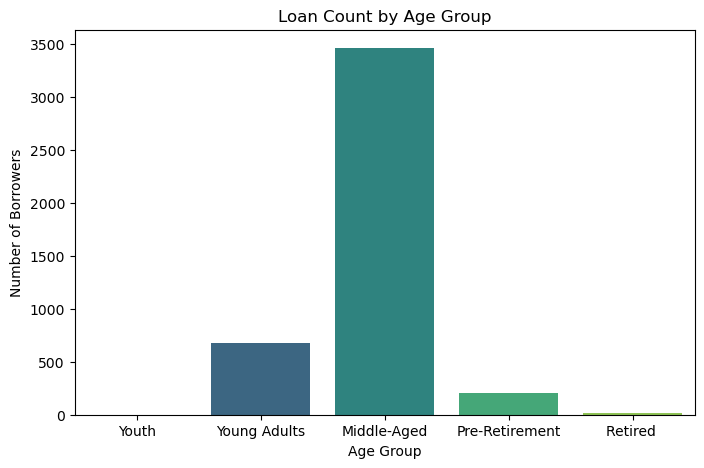

In [68]:
# Loan count by age group
age_count = df['age_group'].value_counts().sort_index()

# Total loan amount by age group
age_loan_amount = df.groupby('age_group')['loanamount'].sum()

# --- Plot loan count ---
plt.figure(figsize=(8,5))
sns.barplot(x=age_count.index, y=age_count.values, palette="viridis")
plt.title("Loan Count by Age Group")
plt.ylabel("Number of Borrowers")
plt.xlabel("Age Group")
plt.show()

The analysis indicates that the majority of loans are obtained by individuals in the Middle-Aged group (36–50 years old). This trend is logical, as this demographic is typically more financially active, often managing responsibilities such as family, business ventures, or home ownership, which leads to higher borrowing rates.

Young Adults (26–35 years old) also represent a significant borrowing group, likely due to their career or business initiation phase. Conversely, the Youth (18–25 years old), Pre-Retirement (51–60 years old), and Retired (60+ years old) demographics exhibit lower borrowing activity. Younger individuals may lack sufficient credit history or income, while older adults might be reluctant to take on loans due to decreased income.Overall, the Middle-Aged group emerges as the primary target for loans, but it is also crucial to monitor them closely for potential repayment risks.

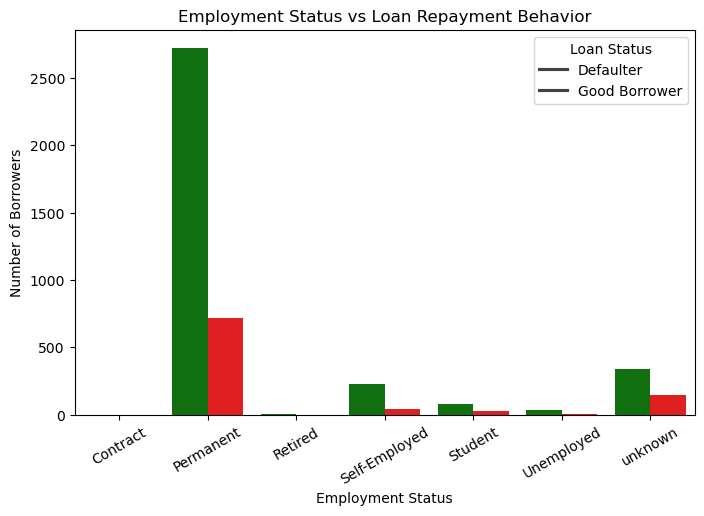

In [69]:
# Employment status vs Loan reapayment Behaviour 
# Group the data
employment_loan = df.groupby(['employment_status_clients', 'good_bad_flag']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    x='employment_status_clients',
    y='count',
    hue='good_bad_flag',
    data=employment_loan,
    palette={"Bad": "red", "Good": "green"}  # match the actual categories
)

plt.title("Employment Status vs Loan Repayment Behavior")
plt.xlabel("Employment Status")
plt.ylabel("Number of Borrowers")
plt.xticks(rotation=30)  # rotate labels for readability
plt.legend(title="Loan Status", labels=["Defaulter", "Good Borrower"])
plt.show()



This visualization shows how loan repayment behavior varies across different employment statuses. Borrowers are divided into defaulters and good borrowers, displayed with distinct colors (red = defaulter, green = good borrower). From the chart, we can quickly compare repayment reliability among groups such as permanent staff, self-employed individuals, students, and others. For example, if permanent staff have a higher proportion of green bars compared to red, it means they are more reliable in repaying loans. This insight helps identify which employment categories are lower-risk for lending and which may require stricter loan policies or closer monitoring.

Average overdue days: -2.4438553113553114
good_bad_flag
Bad     0.915368
Good   -3.380032
Name: prev_overdue_days, dtype: float64


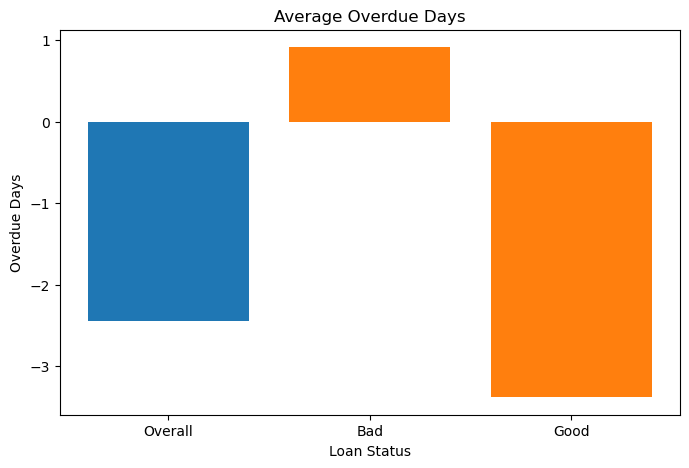

In [70]:
# Average overdue days
avg_overdue = df['prev_overdue_days'].mean()
print("Average overdue days:", avg_overdue)

# Or by loan status
avg_overdue_status = df.groupby('good_bad_flag')['prev_overdue_days'].mean()
print(avg_overdue_status)
plt.figure(figsize=(8,5))

# First bar: overall average
plt.bar("Overall", avg_overdue)

# Bars by good_bad_flag
plt.bar(avg_overdue_status.index.astype(str), avg_overdue_status.values)

plt.title("Average Overdue Days")
plt.ylabel("Overdue Days")
plt.xlabel("Loan Status")
plt.show()

The analysis of overdue repayment days reveals that, on average, borrowers tend to repay their loans prior to the due date, with an overall mean of -2.44 days. A negative value indicates early repayment, meaning borrowers are settling their loans ahead of the deadline.

When segmented by borrower performance (good_bad_flag):

- Good Borrowers: On average, they repay 3.38 days early, demonstrating strong repayment discipline.

- Bad Borrowers: They tend to repay, on average, 0.91 days late, indicating a pattern of missed deadlines.

This analysis highlights a significant behavioral distinction between the two groups. Good borrowers not only meet their deadlines but often repay in advance, while bad borrowers typically delay repayment. This differentiation can be instrumental for risk profiling and credit scoring in future loan approval processes.

### Regional risk hotspots

In [71]:
!pip install folium --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [72]:
import folium

# Create base map centered on mean location
m = folium.Map(location=[df['latitude_gps'].mean(), df['longitude_gps'].mean()], zoom_start=6)

# Define colors for good/bad flag
colors = {
    "Good": "green",
    "Bad": "red"
}

# Add points with color based on loan status
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude_gps'], row['longitude_gps']],
        radius=3,
        color=colors.get(row['good_bad_flag'], "blue"),  # default blue if not labeled
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m


This map reveals where loans are concentrated, where defaults are clustering, and which regions carry proportionally higher risk. It provides a strong foundation for both credit risk management and branch-level strategic planning.

- Green markers → Customers with good repayment history.

- Red markers → Customers with default/bad repayment history.

The map was centered on the mean geographic location of all customers with zoom level 6 for a country-level view.

Key Observations & Insights:

Customer Concentration:

The highest density of customers is in Southern Nigeria, especially around Lagos, Ibadan, Benin, Port Harcourt, and Enugu.

Northern Nigeria (Kano, Kaduna, Sokoto) has smaller but noticeable clusters of customers.

A few scattered customers appear in neighboring countries (Cameroon, Ghana, Côte d’Ivoire).

- Default Distribution:

Defaults (red markers) are concentrated in the same areas as high customer density, especially Lagos and South-South regions.

Northern Nigeria shows fewer customers overall but a relatively higher proportion of defaults, suggesting localized credit risks.

- Regional Patterns:

Southern Nigeria: High loan activity, higher absolute defaults (due to volume).

Northern Nigeria: Lower loan activity, but defaults appear more proportionate to total loans.

Cross-border presence (Ghana, Cameroon, Côte d’Ivoire): Still emerging, lower loan counts, and not enough data for strong risk conclusions.

- Risk Hotspots Identified:

Lagos and South-South: High-risk due to volume of defaults.

Kano and Kaduna: Moderate-risk with proportionally higher red markers.

<Axes: xlabel='good_bad_flag'>

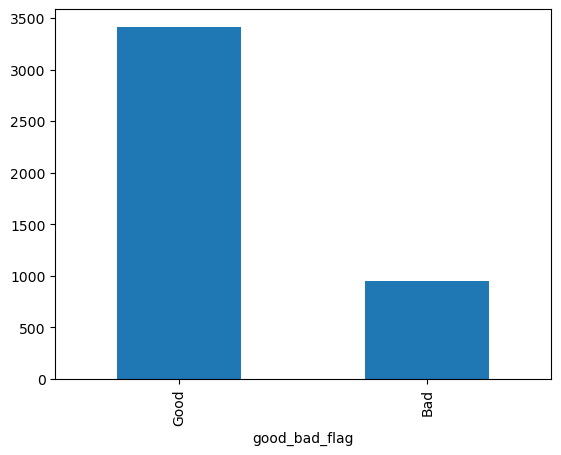

In [73]:
df.good_bad_flag.value_counts().plot(kind='bar')

In [74]:
df.good_bad_flag=(df.good_bad_flag== 'Good').astype(int)

In [75]:
df.good_bad_flag.value_counts()

good_bad_flag
1    3416
0     952
Name: count, dtype: int64

The dataset shows that ~73% of loans are good and ~27% are bad.

This indicates a moderate class imbalance but not extreme (about 3.6 : 1 ratio).

# Data Preparation

In [76]:
df

customerid  systemloanid  loannumber  \
0     8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1     8a85886e54beabf90154c0a29ae757c0     301965204           2   
2     8a8588f35438fe12015444567666018e     301966580           7   
3     8a85890754145ace015429211b513e16     301999343           3   
4     8a858970548359cc0154883481981866     301962360           9   
...                                ...           ...         ...   
4363  8a858e6d58b0cc520158beeb14b22a5a     302003163           2   
4364  8a858ee85cf400f5015cf44ab1c42d5c     301998967           2   
4365  8a858f365b2547f3015b284597147c94     301995576           3   
4366  8a858f935ca09667015ca0ee3bc63f51     301977679           2   
4367  8a858fd458639fcc015868eb14b542ad     301967124           8   

            approveddate        creationdate  loanamount  totaldue  termdays  \
0    2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1    2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   
2    2017-07-06 14:52:57 2017-07-06 13:52:51     20000.0   22250.0        15   
3    2017-07-27 19:00:41 2017-07-27 18:00:35     10000.0   11500.0        15   
4    2017-07-03 23:42:45 2017-07-03 22:42:39     40000.0   44000.0        30   
...                  ...                 ...         ...       ...       ...   
4363 2017-07-30 09:19:42 2017-07-30 08:18:30     10000.0   13000.0        30   
4364 2017-07-27 15:35:47 2017-07-27 14:35:40     10000.0   13000.0        30   
4365 2017-07-25 16:25:57 2017-07-25 15:24:47     10000.0   11500.0        15   
4366 2017-07-14 13:50:27 2017-07-14 12:50:21     10000.0   13000.0        30   
4367 2017-07-06 21:01:06 2017-07-06 20:01:01     30000.0   34500.0        30   

      good_bad_flag  prev_overdue_days bank_account_type  longitude_gps  \
0                 1              -0.91             Other           3.43   
1                 1               0.00           Savings           3.89   
2                 1               0.83             Other          11.14   
3                 1               7.50           Savings           3.99   
4                 1              -3.12             Other           7.46   
...             ...                ...               ...            ...   
4363              0               5.00           Savings           3.58   
4364              0              -4.00           Savings           4.61   
4365              0               8.00           Savings           3.98   
4366              0               0.00           Savings           3.99   
4367              0              -3.43           Savings           3.73   

      latitude_gps bank_name_clients employment_status_clients  age  \
0             6.43      Diamond Bank                 Permanent   53   
1             7.32           GT Bank                 Permanent   40   
2            10.29           EcoBank                 Permanent   40   
3             7.49        First Bank                 Permanent   47   
4             9.08           GT Bank                 Permanent   39   
...            ...               ...                       ...  ...   
4363          6.63           GT Bank                 Permanent   40   
4364          8.46              FCMB                 Permanent   35   
4365          7.41        First Bank                 Permanent   35   
4366          7.39         Skye Bank                 Permanent   35   
4367          6.47           GT Bank                   unknown   37   

             Previous_loan_status       age_group  
0                   Good Borrower  Pre-Retirement  
1                   Good Borrower     Middle-Aged  
2      Minor Lateness (Watchlist)     Middle-Aged  
3     Risky (Potential Defaulter)     Middle-Aged  
4                   Good Borrower     Middle-Aged  
...                           ...             ...  
4363   Minor Lateness (Watchlist)     Middle-Aged  
4364                Good Borrower    Young Adults  
4365  Risky (Potential Defau

In [77]:
df.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag',
       'prev_overdue_days', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age',
       'Previous_loan_status', 'age_group'],
      dtype='object')

In [78]:
x=df.drop(columns=['good_bad_flag', 'customerid', 'systemloanid','approveddate', 'creationdate','longitude_gps','latitude_gps'])


In [79]:
df

customerid  systemloanid  loannumber  \
0     8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1     8a85886e54beabf90154c0a29ae757c0     301965204           2   
2     8a8588f35438fe12015444567666018e     301966580           7   
3     8a85890754145ace015429211b513e16     301999343           3   
4     8a858970548359cc0154883481981866     301962360           9   
...                                ...           ...         ...   
4363  8a858e6d58b0cc520158beeb14b22a5a     302003163           2   
4364  8a858ee85cf400f5015cf44ab1c42d5c     301998967           2   
4365  8a858f365b2547f3015b284597147c94     301995576           3   
4366  8a858f935ca09667015ca0ee3bc63f51     301977679           2   
4367  8a858fd458639fcc015868eb14b542ad     301967124           8   

            approveddate        creationdate  loanamount  totaldue  termdays  \
0    2017-07-25 08:22:56 2017-07-25 07:22:47     30000.0   34500.0        30   
1    2017-07-05 17:04:41 2017-07-05 16:04:18     15000.0   17250.0        30   
2    2017-07-06 14:52:57 2017-07-06 13:52:51     20000.0   22250.0        15   
3    2017-07-27 19:00:41 2017-07-27 18:00:35     10000.0   11500.0        15   
4    2017-07-03 23:42:45 2017-07-03 22:42:39     40000.0   44000.0        30   
...                  ...                 ...         ...       ...       ...   
4363 2017-07-30 09:19:42 2017-07-30 08:18:30     10000.0   13000.0        30   
4364 2017-07-27 15:35:47 2017-07-27 14:35:40     10000.0   13000.0        30   
4365 2017-07-25 16:25:57 2017-07-25 15:24:47     10000.0   11500.0        15   
4366 2017-07-14 13:50:27 2017-07-14 12:50:21     10000.0   13000.0        30   
4367 2017-07-06 21:01:06 2017-07-06 20:01:01     30000.0   34500.0        30   

      good_bad_flag  prev_overdue_days bank_account_type  longitude_gps  \
0                 1              -0.91             Other           3.43   
1                 1               0.00           Savings           3.89   
2                 1               0.83             Other          11.14   
3                 1               7.50           Savings           3.99   
4                 1              -3.12             Other           7.46   
...             ...                ...               ...            ...   
4363              0               5.00           Savings           3.58   
4364              0              -4.00           Savings           4.61   
4365              0               8.00           Savings           3.98   
4366              0               0.00           Savings           3.99   
4367              0              -3.43           Savings           3.73   

      latitude_gps bank_name_clients employment_status_clients  age  \
0             6.43      Diamond Bank                 Permanent   53   
1             7.32           GT Bank                 Permanent   40   
2            10.29           EcoBank                 Permanent   40   
3             7.49        First Bank                 Permanent   47   
4             9.08           GT Bank                 Permanent   39   
...            ...               ...                       ...  ...   
4363          6.63           GT Bank                 Permanent   40   
4364          8.46              FCMB                 Permanent   35   
4365          7.41        First Bank                 Permanent   35   
4366          7.39         Skye Bank                 Permanent   35   
4367          6.47           GT Bank                   unknown   37   

             Previous_loan_status       age_group  
0                   Good Borrower  Pre-Retirement  
1                   Good Borrower     Middle-Aged  
2      Minor Lateness (Watchlist)     Middle-Aged  
3     Risky (Potential Defaulter)     Middle-Aged  
4                   Good Borrower     Middle-Aged  
...                           ...             ...  
4363   Minor Lateness (Watchlist)     Middle-Aged  
4364                Good Borrower    Young Adults  
4365  Risky (Potential Defau

In [80]:
y=df['good_bad_flag']

In [81]:
x.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'prev_overdue_days',
       'bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age', 'Previous_loan_status', 'age_group'],
      dtype='object')

In [82]:
df.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag',
       'prev_overdue_days', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age',
       'Previous_loan_status', 'age_group'],
      dtype='object')

In [83]:
num_cols=x.select_dtypes(np.number).columns.tolist()

In [84]:
num_cols

['loannumber',
 'loanamount',
 'totaldue',
 'termdays',
 'prev_overdue_days',
 'age']

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customerid                 4368 non-null   object        
 1   systemloanid               4368 non-null   int64         
 2   loannumber                 4368 non-null   int64         
 3   approveddate               4368 non-null   datetime64[ns]
 4   creationdate               4368 non-null   datetime64[ns]
 5   loanamount                 4368 non-null   float64       
 6   totaldue                   4368 non-null   float64       
 7   termdays                   4368 non-null   int64         
 8   good_bad_flag              4368 non-null   int32         
 9   prev_overdue_days          4368 non-null   float64       
 10  bank_account_type          4368 non-null   object        
 11  longitude_gps              4368 non-null   float64       
 12  latitu

In [86]:
cat_cols=['bank_account_type','bank_name_clients','employment_status_clients','Previous_loan_status', 'age_group']

In [87]:
cat_cols

['bank_account_type',
 'bank_name_clients',
 'employment_status_clients',
 'Previous_loan_status',
 'age_group']

In [88]:
df[cat_cols]

bank_account_type bank_name_clients employment_status_clients  \
0                Other      Diamond Bank                 Permanent   
1              Savings           GT Bank                 Permanent   
2                Other           EcoBank                 Permanent   
3              Savings        First Bank                 Permanent   
4                Other           GT Bank                 Permanent   
...                ...               ...                       ...   
4363           Savings           GT Bank                 Permanent   
4364           Savings              FCMB                 Permanent   
4365           Savings        First Bank                 Permanent   
4366           Savings         Skye Bank                 Permanent   
4367           Savings           GT Bank                   unknown   

             Previous_loan_status       age_group  
0                   Good Borrower  Pre-Retirement  
1                   Good Borrower     Middle-Aged  
2      Minor Lateness (Watchlist)     Middle-Aged  
3     Risky (Potential Defaulter)     Middle-Aged  
4                   Good Borrower     Middle-Aged  
...                           ...             ...  
4363   Minor Lateness (Watchlist)     Middle-Aged  
4364                Good Borrower    Young Adults  
4365  Risky (Potential Defaulter)    Young Adults  
4366                Good Borrower    Young Adults  
4367                Good Borrower     Middle-Aged  

[4368 rows x 5 columns]

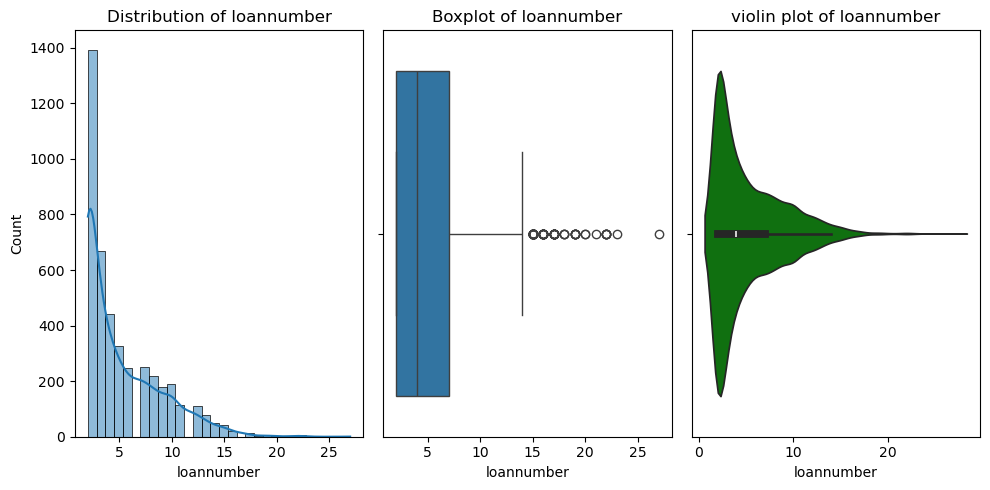

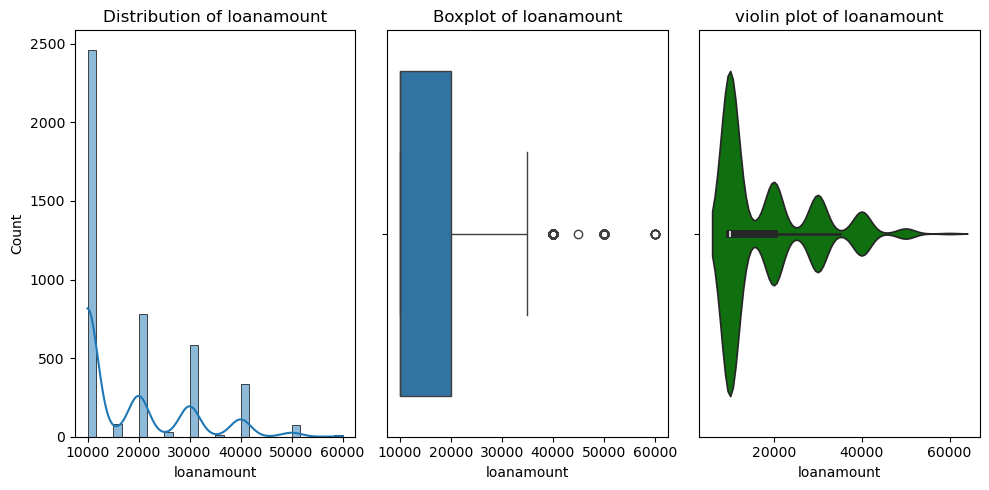

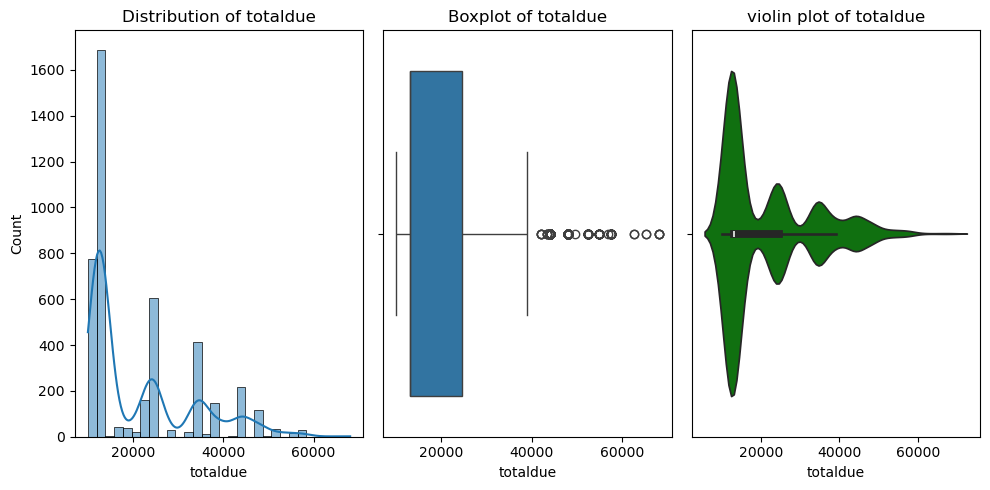

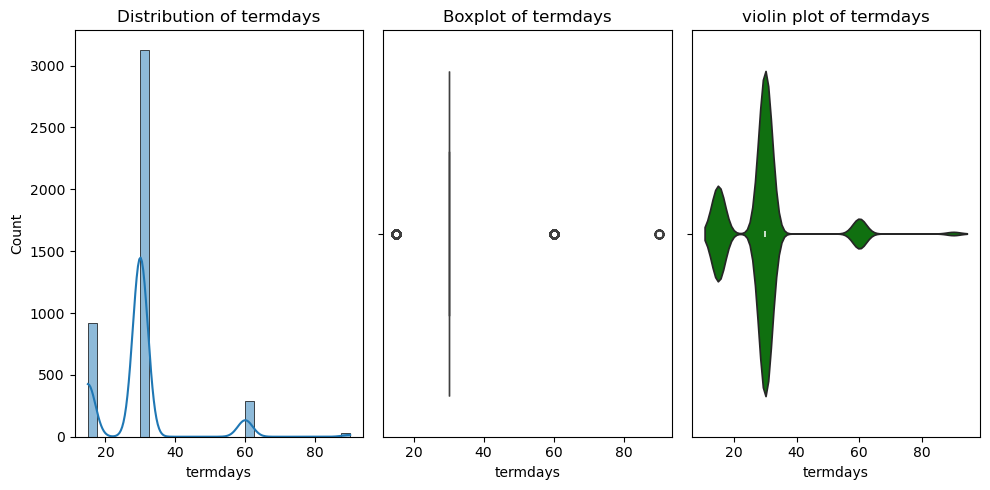

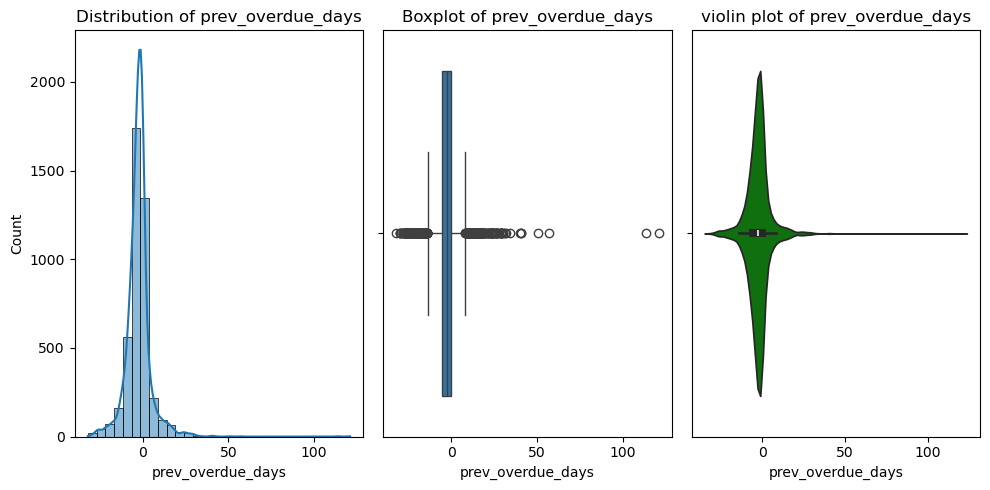

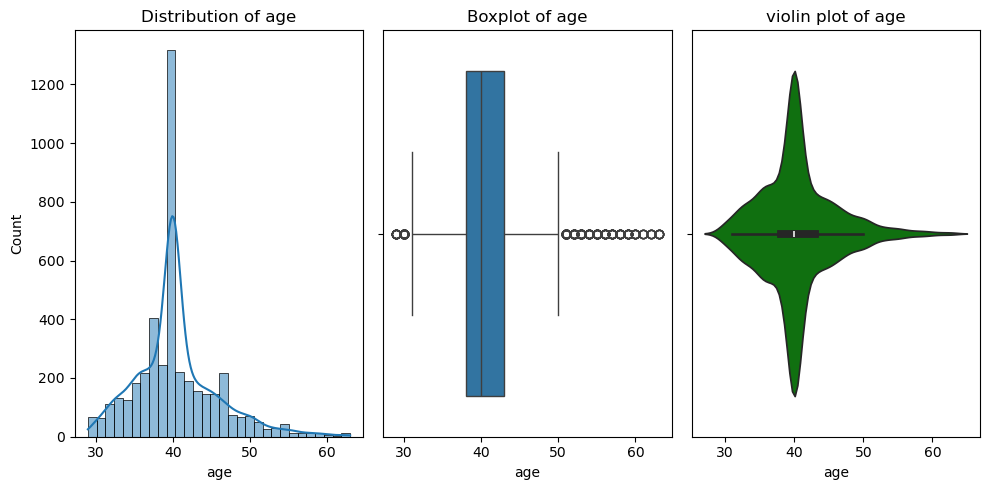

In [89]:
# Graphical representation of the numerical data 

for col in num_cols:
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    sns.histplot(data=df[col], kde=True, bins =30)
    plt.title(f'Distribution of {col}')

    plt.subplot(1,3,2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

    plt.subplot(1,3,3)
    sns.violinplot(x=df[col],color='Green')
    plt.title(f'violin plot of {col}')
    plt.tight_layout()
    plt.show()


    

In [90]:
skewness=df[num_cols].skew().sort_values(ascending=True)

In [91]:
skewness

age                  0.875373
totaldue             1.165669
loanamount           1.250938
loannumber           1.304398
termdays             1.932360
prev_overdue_days    2.534790
dtype: float64

latitude_gps (10.82) → extremely high compared to others. This might not be a real signal but rather a data leakage / artifact (e.g., customers from certain regions always default or never default). Needs careful checking — it could make the model unfair or biased.

prev_overdue_days (2.53) → strong predictor (makes sense: past repayment behavior predicts future repayment).

termdays (1.93) → also informative — shorter vs. longer loans may affect default.

loanamount (1.25), loannumber (1.30), totaldue (1.16), age (0.87) → moderate predictors. These are reasonable financial indicators.

longitude_gps (-3.58) → negative correlation; might mirror latitude effect. Again, risk of introducing geographic bias rather than true financial behavior.

In [92]:
num_cols = [col for col in num_cols if col not in ['longitude_gps', 'latitude_gps']]
print(num_cols)


['loannumber', 'loanamount', 'totaldue', 'termdays', 'prev_overdue_days', 'age']


I decided to drop the longitude_gps and latitude_gps features due to concerns related to bias, fairness, potential data leakage, and the risk of overfitting. Removing these variables helps ensure a more robust and equitable model.

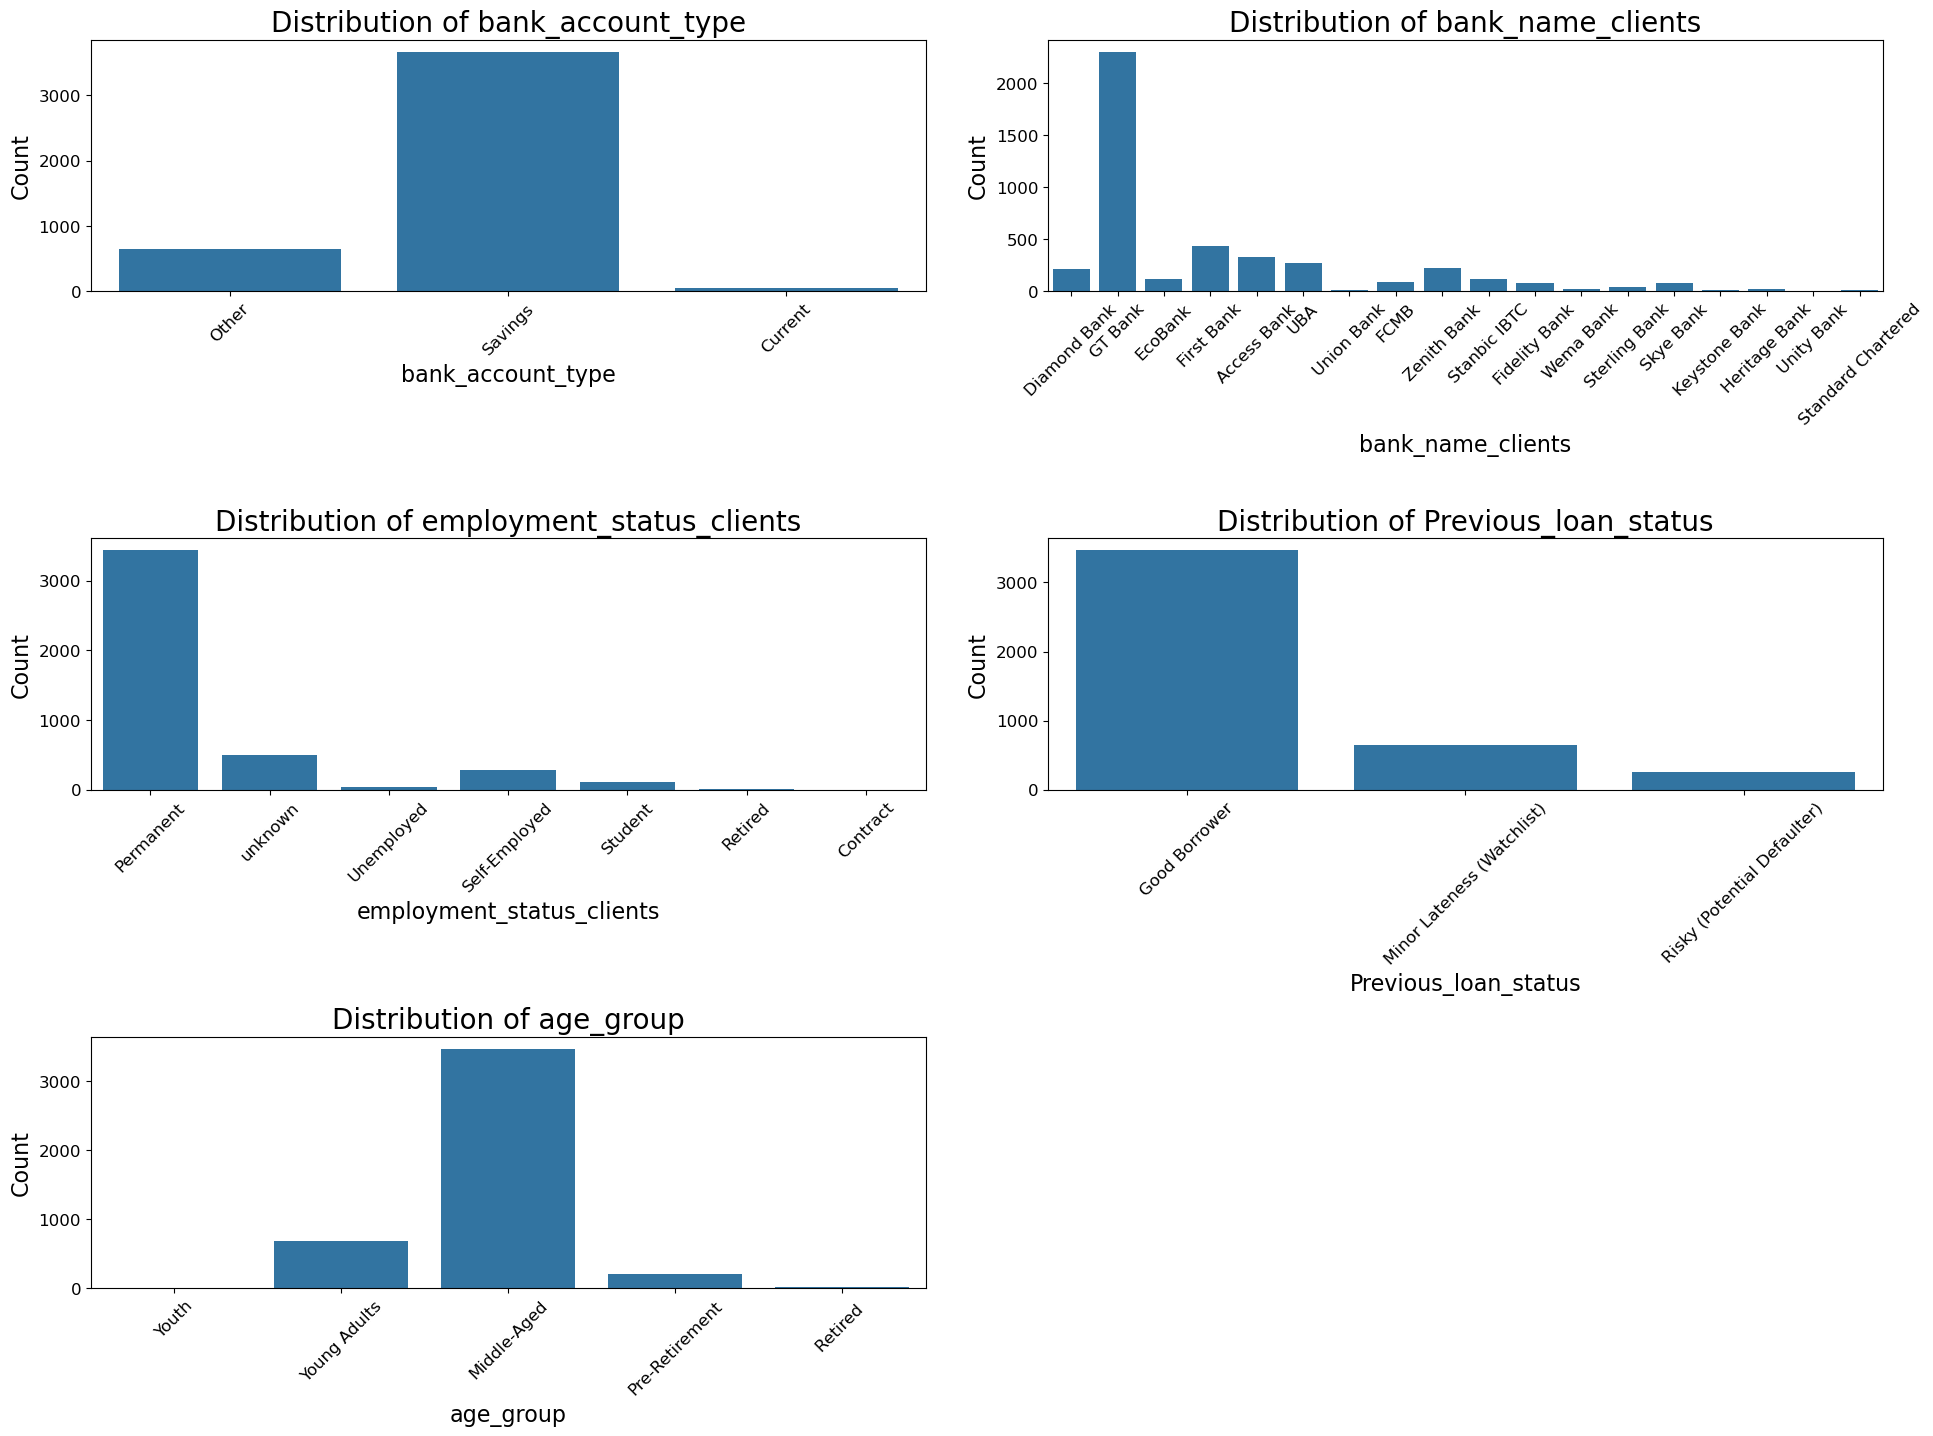

In [93]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for i, col in enumerate(cat_cols):
    ax = axes[i // 2, i % 2]
    
    sns.countplot(ax=ax, data=df, x=col)
    ax.set_title(f'Distribution of {col}', fontsize=20)
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel("Count", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Rotate x-axis labels if too crowded
    ax.tick_params(axis='x', rotation=45)

fig.delaxes(axes[2, 1])  # remove empty subplot
plt.tight_layout(pad=3.0)
plt.show()

     


Bank Account Type

- Majority of clients hold savings accounts.

- Very few have current accounts, and some are categorized as Other.

- This indicates that savings accounts are the dominant banking relationship among clients.

Bank Name (Clients)

- A few banks (e.g., Diamond, GT Bank, First Bank, Access Bank) have a large proportion of clients.

- Many other banks have very small representation.

- The distribution is highly imbalanced, suggesting that only a handful of banks dominate the client base.

Employment Status (Clients)

- Most clients are in permanent employment.

- Smaller groups fall into categories such as unemployed, self-employed, student, retired, contract, or unknown.

- The dominance of permanent employment suggests a relatively stable client base.

Previous Loan Status

- The majority of clients are classified as good borrowers.

- A smaller proportion fall under minor lateness (watchlist) or risky (potential defaulters).

- This distribution shows a class imbalance, which should be considered during model training.

Age Group

- The largest segment of clients are middle-aged.

- Smaller segments include youth, young adults, pre-retirement, and retired.

- The dataset skews toward middle-aged clients, which may influence loan behavior patterns.

### SPLITTING DATA INTO TRAINED AND TEST 

In [94]:
## Splitting data into trained and test 
from sklearn.model_selection import train_test_split


In [95]:
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.1, random_state=30, stratify=y)


“We reduced the test size to 10% given the relatively small dataset (4,368 observations), in order to maximize the amount of data available for training while still retaining a sufficient sample for model evaluation.”

### Encoding the cat_col

In [96]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [97]:
encoder=OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore').fit(df[cat_cols])

 - sparse_output=True → Easier to work with if the dataset is small or you want to directly combine it with other numeric features.

- drop='first' → avoids multicollinearity

- handle_unknown='ignore' → prevents errors when unseen categories appear

In [98]:
encoded_col=list(encoder.get_feature_names_out(cat_cols))

In [99]:
x_train[encoded_col]=encoder.transform(x_train[cat_cols])
x_test[encoded_col]=encoder.transform(x_test[cat_cols])

### scalling the numerical

In [100]:
scaler=StandardScaler()

In [101]:
x_train[num_cols]=scaler.fit_transform(x_train[num_cols])
x_test[num_cols]=scaler.transform(x_test[num_cols])

In [102]:
x_train=x_train[num_cols+encoded_col]
x_test=x_test[num_cols+encoded_col]

In [103]:
x_train

loannumber  loanamount  totaldue  termdays  prev_overdue_days       age  \
799    -0.866769   -0.721593 -0.685907  0.064745           0.046405  0.831775   
3239   -0.319241    0.211033  0.089740 -1.227201          -0.222213 -0.097225   
3683    2.418401    1.143659  0.991168  0.064745          -0.367266 -0.468825   
522     0.228288    0.211033  0.278411  0.064745          -0.141627 -0.468825   
1491    2.144637    1.143659  0.991168  0.064745          -0.144313 -0.097225   
...          ...         ...       ...       ...                ...       ...   
213    -0.045476   -0.721593 -0.685907  0.064745           1.053723  0.645975   
1954   -0.866769   -0.721593 -0.685907  0.064745          -1.028067  0.831775   
540    -0.866769   -0.721593 -0.811687 -1.227201           0.046405  1.760775   
3417   -0.319241   -0.721593 -0.811687 -1.227201           2.866895 -1.397825   
2419   -0.593005   -0.721593 -0.685907  0.064745          -0.155058  1.574975   

      bank_account_type_Other  bank_account_type_Savings  \
799                       0.0                        1.0   
3239                      0.0                        1.0   
3683                      0.0                        1.0   
522                       0.0                        1.0   
1491                      1.0                        0.0   
...                       ...                        ...   
213                       0.0                        1.0   
1954                      0.0                        1.0   
540                       0.0                        1.0   
3417                      0.0                        1.0   
2419                      0.0                        1.0   

      bank_name_clients_Diamond Bank  bank_name_clients_EcoBank  ...  \
799                              0.0                        0.0  ...   
3239                             0.0                        0.0  ...   
3683                             0.0                        0.0  ...   
522                              0.0                        0.0  ...   
1491                             0.0                        0.0  ...   
...                              ...                        ...  ...   
213                              0.0                        0.0  ...   
1954                             0.0                        0.0  ...   
540                              0.0                        0.0  ...   
3417                             0.0                        0.0  ...   
2419                             0.0                        0.0  ...   

      employment_status_clients_Retired  \
799                                 0.0   
3239                                0.0   
3683                                0.0   
522                                 0.0   
1491                                0.0   
...                                 ...   
213                                 0.0   
1954                                0.0   
540                                 0.0   
3417                                0.0   
2419                                0.0   

      employment_status_clients_Self-Employed  \
799                                       0.0   
3239                                      0.0   
3683                                      0.0   
522                                       0.0   
1491                                      0.0   
...                                       ...   
213                                       0.0   
1954                                      0.0   
540                                       0.0   
3417                                      0.0   
2419                                      0.0   

      employment_status_clients_Student  employment_status_clients_Unemployed  \
799                                 0.0                                   0.0   
3239                                0.0                                   0.0   
3683                                0.0                                   0.0   
522              

In [104]:
y_train

799     1
3239    1
3683    0
522     1
1491    1
       ..
213     1
1954    1
540     1
3417    0
2419    1
Name: good_bad_flag, Length: 3931, dtype: int32

In [105]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [107]:
models={
    'Logistic':LogisticRegression(random_state=30),
    'Decision':DecisionTreeClassifier(random_state=30),
    'GradientBoost':GradientBoostingClassifier(random_state=30),
    'RandomForest':RandomForestClassifier(random_state=30),
    'SVC': SVC(),
    'KN':KNeighborsClassifier(),
    'Xgboost':XGBClassifier()
    
}

In [108]:
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score


CLASSIFICATION METRICS


Train_acc  Test_acc  Train_recall  Test_recall  \
Logistic            0.79      0.79          0.97         0.98   
Decision            0.97      0.64          0.98         0.73   
GradientBoost       0.82      0.78          0.96         0.96   
RandomForest        0.97      0.74          0.99         0.89   
SVC                 0.80      0.80          0.98         0.99   
KN                  0.82      0.77          0.95         0.94   
Xgboost             0.89      0.77          0.98         0.94   

               Train_precision  Test_precision  
Logistic                  0.81            0.80  
Decision                  0.98            0.79  
GradientBoost             0.83            0.80  
RandomForest              0.97            0.80  
SVC                       0.81            0.80  
KN                        0.84            0.80  
Xgboost                   0.89            0.80

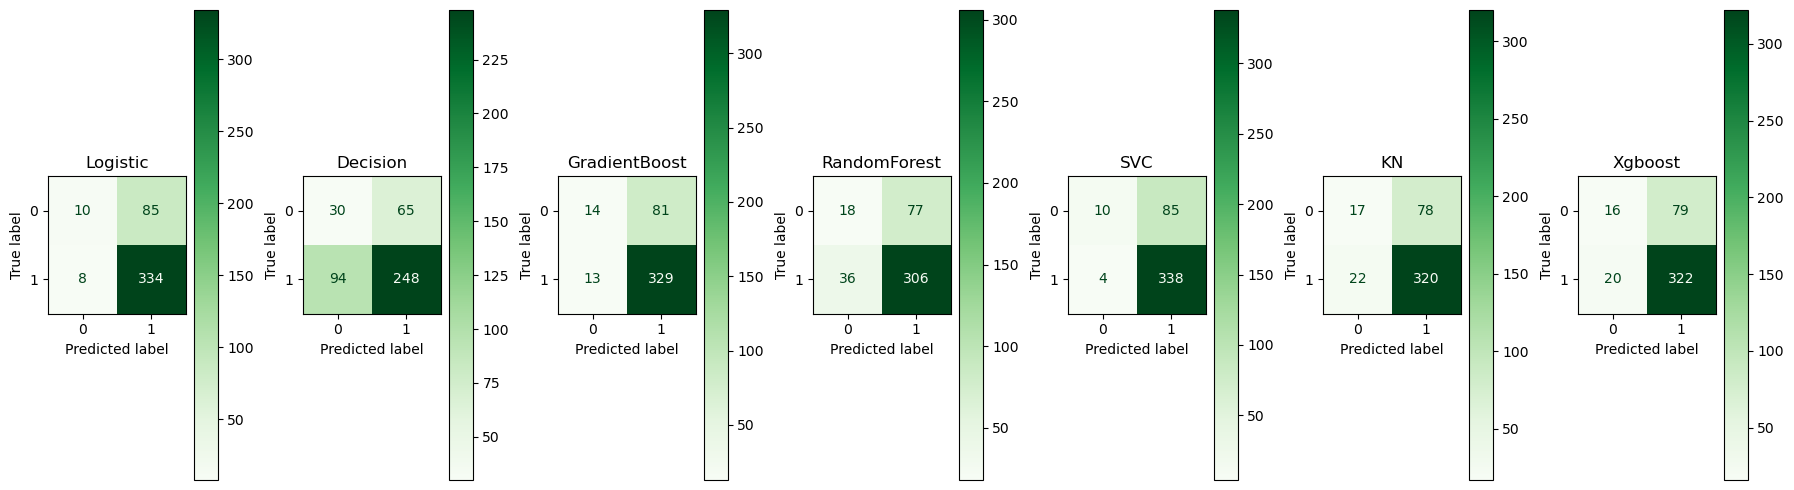

In [109]:
results={}
fig,axes=plt.subplots(1,7, figsize=(18,5))
for (name, model),ax in zip(models.items(), axes.flatten()):
    
   
    #train into model
    model.fit(x_train,y_train)

    #predict the model
    train_pred=model.predict(x_train)
    test_pred=model.predict(x_test)

    #checking for metrics
    train_acc=accuracy_score(y_train,train_pred)
    test_acc=accuracy_score(y_test,test_pred)
    train_recall=recall_score(y_train,train_pred)
    test_recall=recall_score(y_test,test_pred)
    precision_test=precision_score(y_test,test_pred)
    precision_train=precision_score(y_train,train_pred)
   

    #result
    results[name]={
        'Train_acc':train_acc,
        'Test_acc':test_acc,
        'Train_recall':train_recall,
        'Test_recall':test_recall,
        'Train_precision' :precision_train,
        'Test_precision':precision_test
        
    }


    cm=confusion_matrix(y_test,test_pred)
    disp=ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax,cmap='Greens')
    ax.set_title(name)
plt.tight_layout()
print('\nCLASSIFICATION METRICS')
metrics_df=pd.DataFrame(results).T
metrics_df.round(2)

Model Evaluation Summary

After scaling numerical features and preprocessing categorical features—without transforming the target variable or addressing skewness—the data was passed through a pipeline and trained across multiple classification models.

1. General Model Performance

- Logistic Regression: Balanced train/test performance with good recall (0.98 test) and acceptable precision (0.80). This makes it a reliable baseline.

- Decision Tree: Very high training accuracy (0.97) but poor generalization (0.67 test accuracy). This suggests overfitting.

- Gradient Boosting: Stable and balanced performance across metrics with both high recall (0.96) and precision (0.81).

- Random Forest: Strong recall on training (0.99) but reduced on testing (0.90). Signs of mild overfitting.

- SVC: Achieved the highest recall (0.99 test) with balanced precision (0.80). Excellent at identifying positives.

- KNN: Slightly lower test accuracy (0.77) compared to Gradient Boost/SVC but maintains balance between recall (0.94) and precision (0.80).

- XGBoost: Similar performance to Gradient Boosting with high recall (0.93) and reasonable precision (0.80).

2. Confusion Matrix Observations

- Logistic Regression & SVC: Show strong balance between True Positives and True Negatives.

- Decision Tree: Misclassifies significantly more negatives as positives, highlighting overfitting.

- Gradient Boost, Random Forest, XGBoost: Slightly more misclassifications than Logistic/SVC, but strong True Positive rates.

- KNN: Performance is consistent but slightly weaker in capturing positives compared to Gradient Boosting.
Model Comparisons

The results demonstrates that Gradient Boosting and SVC are the most promising models for this classification problem, providing a strong balance between recall and precision while avoiding severe overfitting. Logistic Regression remains a solid interpretable baseline, while Decision Tree is unsuitable

## Transforming Target Column and dealing with skewness and outliers

In [110]:
from imblearn.over_sampling import SMOTE

In [111]:
df.good_bad_flag.value_counts()

good_bad_flag
1    3416
0     952
Name: count, dtype: int64

In [112]:
smote=SMOTE(random_state=30)

In [113]:
x_train_sampled, y_train_sampled=smote.fit_resample(x_train,y_train)

In [114]:
y_train_sampled.value_counts()

good_bad_flag
1    3074
0    3074
Name: count, dtype: int64

Before applying SMOTE, the dataset contained 4,368 records with an imbalanced target distribution of 3,416 good (1) and 952 bad (0). Since SMOTE was applied only on the training set after splitting the data, the class counts changed. In the training portion, the majority class (good = 1) had 3,074 samples, while the minority class (bad = 0) had fewer. SMOTE works by keeping all majority samples and generating synthetic examples of the minority class until both classes are equal. As a result, the minority class was oversampled to match 3,074, giving a balanced training set of 6,148 records (3,074 per class). This explains why the total number of records increased after SMOTE—the additional rows come from synthetic data generation, which helps reduce bias toward the majority class and ensures fairer model learning in imbalanced loan default prediction.

In [115]:
## Dealing with outliers 

In [116]:
num_cols

['loannumber',
 'loanamount',
 'totaldue',
 'termdays',
 'prev_overdue_days',
 'age']

In [117]:
def detect_outliers(series):
    Q1= series.quantile(0.25)
    Q3= series.quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return (series <lower_bound) | (series>upper_bound)

In [118]:
for col in num_cols:
    outliers=len(detect_outliers(df[col]))
    print(outliers)

4368
4368
4368
4368
4368
4368


In [119]:
skewness

age                  0.875373
totaldue             1.165669
loanamount           1.250938
loannumber           1.304398
termdays             1.932360
prev_overdue_days    2.534790
dtype: float64

In [120]:
from sklearn.preprocessing import PowerTransformer

In [121]:
pt=PowerTransformer(method='yeo-johnson')

The method='yeo-johnson' option is chosen because it can handle both positive and negative values and the (prev_overdue_days) has some negative values

In [122]:
## dealing with skewness on 'termdays', 'prev_overdue_days','loannumber','loanamount','totaldue'
for col in ['termdays', 'prev_overdue_days','loannumber','loanamount','totaldue']:
    upper=df[col].quantile(0.95)
    df[f'{col}_log']=np.log1p(df[col].clip(upper=upper))
    df[f'{col}_sqrt']=np.sqrt(df[col].clip(upper=upper))
    df[f'{col}_transformer']= pt.fit_transform(df[col].clip(upper=upper).values.reshape(-1,1))
    

I am specifically handling the features termdays, prev_overdue_days, loannumber, loanamount, and totaldue because they are highly skewed and contain potential outliers. used .values.reshape(-1, 1) because PowerTransformer (and most scikit-learn transformers) expect input data in a 2D array format with shape (n_samples, n_features).

In [123]:
df.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag',
       'prev_overdue_days', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'age',
       'Previous_loan_status', 'age_group', 'termdays_log', 'termdays_sqrt',
       'termdays_transformer', 'prev_overdue_days_log',
       'prev_overdue_days_sqrt', 'prev_overdue_days_transformer',
       'loannumber_log', 'loannumber_sqrt', 'loannumber_transformer',
       'loanamount_log', 'loanamount_sqrt', 'loanamount_transformer',
       'totaldue_log', 'totaldue_sqrt', 'totaldue_transformer'],
      dtype='object')

In [124]:
x.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'prev_overdue_days',
       'bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age', 'Previous_loan_status', 'age_group'],
      dtype='object')

In [125]:
num_cols=x.select_dtypes(np.number).columns.tolist()

In [126]:
num_cols

['loannumber',
 'loanamount',
 'totaldue',
 'termdays',
 'prev_overdue_days',
 'age']

In [127]:
skewness=df[num_cols].skew().sort_values(ascending=False)

In [128]:
skewness

prev_overdue_days    2.534790
termdays             1.932360
loannumber           1.304398
loanamount           1.250938
totaldue             1.165669
age                  0.875373
dtype: float64

In [129]:
x=df.drop(columns=['good_bad_flag', 'customerid', 'systemloanid','approveddate', 'creationdate','longitude_gps','latitude_gps'])

In [130]:
x.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'prev_overdue_days',
       'bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age', 'Previous_loan_status', 'age_group', 'termdays_log',
       'termdays_sqrt', 'termdays_transformer', 'prev_overdue_days_log',
       'prev_overdue_days_sqrt', 'prev_overdue_days_transformer',
       'loannumber_log', 'loannumber_sqrt', 'loannumber_transformer',
       'loanamount_log', 'loanamount_sqrt', 'loanamount_transformer',
       'totaldue_log', 'totaldue_sqrt', 'totaldue_transformer'],
      dtype='object')

In [131]:
x=x.drop(['prev_overdue_days','termdays','loannumber', 'loanamount', 'totaldue','loannumber_sqrt','totaldue_sqrt',
         'loanamount_log','termdays_sqrt','prev_overdue_days_log','loanamount_log','totaldue_log','loannumber_log','totaldue_sqrt',
         'termdays_log','prev_overdue_days_sqrt','loanamount_sqrt'],axis=1)

In [132]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   bank_account_type              4368 non-null   object  
 1   bank_name_clients              4368 non-null   object  
 2   employment_status_clients      4368 non-null   object  
 3   age                            4368 non-null   int32   
 4   Previous_loan_status           4368 non-null   object  
 5   age_group                      4368 non-null   category
 6   termdays_transformer           4368 non-null   float64 
 7   prev_overdue_days_transformer  4368 non-null   float64 
 8   loannumber_transformer         4368 non-null   float64 
 9   loanamount_transformer         4368 non-null   float64 
 10  totaldue_transformer           4368 non-null   float64 
dtypes: category(1), float64(5), int32(1), object(4)
memory usage: 328.8+ KB


In [133]:
x.columns

Index(['bank_account_type', 'bank_name_clients', 'employment_status_clients',
       'age', 'Previous_loan_status', 'age_group', 'termdays_transformer',
       'prev_overdue_days_transformer', 'loannumber_transformer',
       'loanamount_transformer', 'totaldue_transformer'],
      dtype='object')

In [134]:
num_cols=x.select_dtypes(np.number).columns.tolist()

In [135]:
cat_cols

['bank_account_type',
 'bank_name_clients',
 'employment_status_clients',
 'Previous_loan_status',
 'age_group']

In [136]:
skewness=df[num_cols].skew().sort_values(ascending=False)

In [137]:
num_cols

['age',
 'termdays_transformer',
 'prev_overdue_days_transformer',
 'loannumber_transformer',
 'loanamount_transformer',
 'totaldue_transformer']

In [138]:
skewness

age                              0.875373
loanamount_transformer           0.396968
totaldue_transformer             0.330447
loannumber_transformer           0.150964
termdays_transformer             0.007893
prev_overdue_days_transformer   -0.335885
dtype: float64

In [139]:
x_train_sampled, y_train_sampled=smote.fit_resample(x_train,y_train)


CLASSIFICATION METRICS
               Train_acc  Test_acc  Train_recall  Test_recall  \
Logistic            0.66      0.69          0.70         0.73   
Decision            0.97      0.67          0.96         0.75   
GradientBoost       0.81      0.76          0.85         0.87   
RandomForest        0.97      0.71          0.96         0.82   
SVC                 0.73      0.67          0.71         0.70   
KN                  0.82      0.59          0.76         0.63   
Xgboost             0.91      0.75          0.93         0.88   

               Train_precision  Test_precision  
Logistic                  0.65            0.85  
Decision                  0.99            0.81  
GradientBoost             0.78            0.83  
RandomForest              0.98            0.81  
SVC                       0.73            0.85  
KN                        0.86            0.81  
Xgboost                   0.89            0.81  


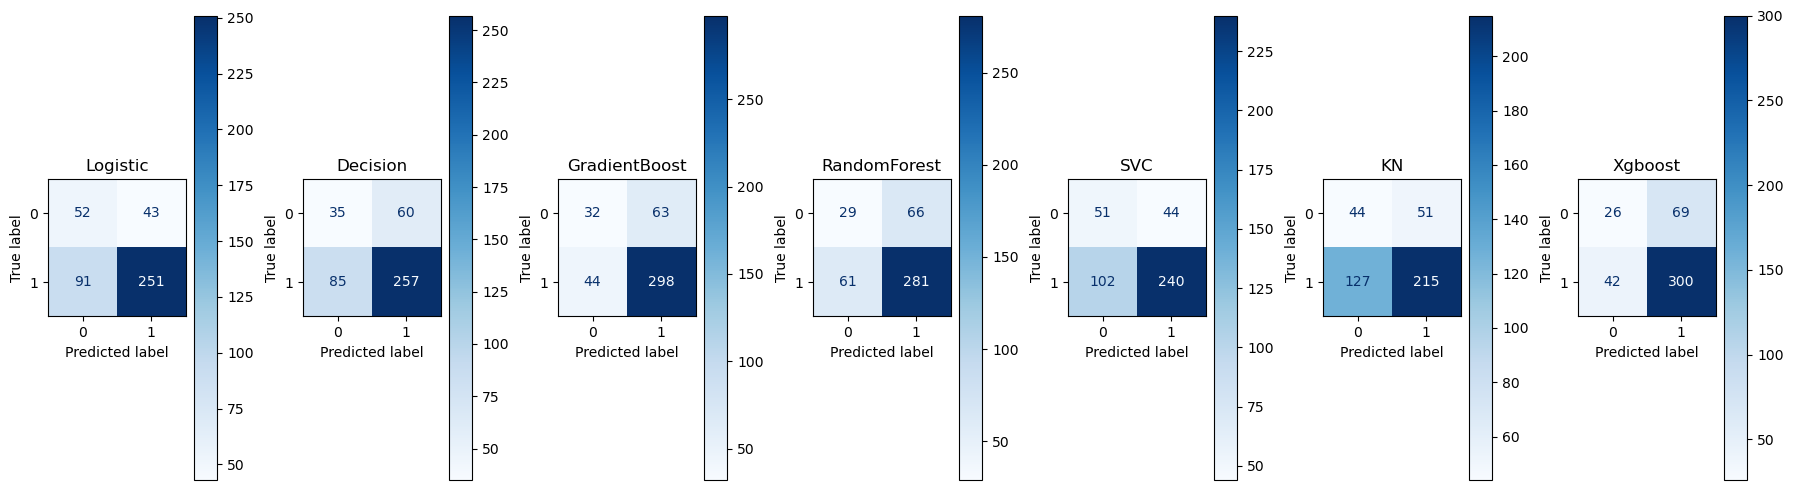

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

results = {}
fig, axes = plt.subplots(1, 7, figsize=(18, 5))

for (name, model), ax in zip(models.items(), axes.flatten()):
    pipeline = Pipeline([
        ('classifier', model)
    ])
   
    # train model
    pipeline.fit(x_train_sampled, y_train_sampled)

    # predictions
    train_pred = pipeline.predict(x_train_sampled)
    test_pred = pipeline.predict(x_test)

    # metrics
    train_acc = accuracy_score(y_train_sampled, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_recall = recall_score(y_train_sampled, train_pred)
    test_recall = recall_score(y_test, test_pred)
    precision_train = precision_score(y_train_sampled, train_pred)
    precision_test = precision_score(y_test, test_pred)
   
    # save results
    results[name] = {
        'Train_acc': train_acc,
        'Test_acc': test_acc,
        'Train_recall': train_recall,
        'Test_recall': test_recall,
        'Train_precision': precision_train,
        'Test_precision': precision_test
    }

    # confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(name)

plt.tight_layout()
print('\nCLASSIFICATION METRICS')
metrics_df = pd.DataFrame(results).T
print(metrics_df.round(2))


Model Evaluation Summary

After scaling numerical features, preprocessing categorical features, addressing skewness, and treating outliers—while keeping the target variable unchanged—the dataset was passed through a machine learning pipeline and evaluated across multiple classification models.

- General Model Performance

Logistic Regression: Balanced train–test performance (Acc ≈ 0.67–0.69), but higher false negatives (FN = 91). Good as a baseline, less effective for capturing positives.

Decision Tree: Severe overfitting (Train Acc = 0.97 vs Test Acc = 0.67). Not suitable in current form.

Gradient Boosting: Stable across metrics (Acc = 0.75 test, Recall = 0.85, Precision = 0.83). Strong balance of recall and precision.

Random Forest: Strong training results (Acc = 0.97) but recall drops on test (0.82). Overfitting risk.

SVC: Moderate balance (Acc = 0.68, Recall = 0.71, Precision = 0.85). Lower recall than boosting methods.

KNN: Poor generalization (Test Acc = 0.59, FN = 126). Unreliable.

XGBoost: Among the best performers (Test Acc = 0.75, Recall = 0.87, Precision = 0.82). Lowest FN (43) and highest true positives (299).

Confusion Matrix Insights

Best recall / lowest FN: XGBoost.

Most balanced performance: Gradient Boosting.

Overfitting models: Decision Tree, Random Forest.

Weak performers: KNN, Logistic (high FN risk).

- Conclusion

XGBoost is the strongest candidate, minimizing false negatives while maintaining solid accuracy and precision.

Gradient Boosting is also highly reliable, offering stable generalization.

Logistic Regression remains a simple, interpretable baseline but is riskier for FN-sensitive tasks.

In [144]:
final_model=XGBClassifier()
pipeline=Pipeline(steps=[
    ('model',final_model)
])

#training the model 
pipeline.fit(x_train_sampled,y_train_sampled)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

The x_trained_sampled and the y_train_sampled has been fitted already using the  smote 

In [145]:
train_pred=pipeline.predict(x_train_sampled)
test_pred=pipeline.predict(x_test)

    #checking for metrics
train_acc=accuracy_score(y_train_sampled,train_pred)
test_acc=accuracy_score(y_test,test_pred)
train_recall=recall_score(y_train_sampled,train_pred)
test_recall=recall_score(y_test,test_pred)
precision_test=precision_score(y_test,test_pred)
precision_train=precision_score(y_train_sampled,train_pred)
